# Case Study

## Setup

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
#Help funcs for colored output
from termcolor import colored, cprint
def green(txt):
    return colored(txt, 'green')
def red(txt):
    return colored(txt, 'red')
def blue(txt):
    return colored(txt, 'cyan')
def bold(txt):
    return colored(txt, attrs=['bold'])

In [49]:
#Get raw Data
df = pd.read_csv("data/house_data_training.csv", sep=';') 
# remove unnamed column
df = df.iloc[:, 1:]
#Transform string to datetime
df["date"] = pd.to_datetime(df["date"])
df.tail()
#Drop rows with NaN values

maeList = []#for model selection

In Task 01 we have identified 3 lines with missing values. Due to the size of the data set, we can use the listwise Deletion - method at this point.

In [50]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14997 entries, 0 to 14999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             14997 non-null  int64         
 1   date           14997 non-null  datetime64[ns]
 2   price          14997 non-null  float64       
 3   bedrooms       14997 non-null  int64         
 4   bathrooms      14997 non-null  float64       
 5   sqft_living    14997 non-null  int64         
 6   sqft_lot       14997 non-null  int64         
 7   floors         14997 non-null  float64       
 8   waterfront     14997 non-null  float64       
 9   dis_super      14997 non-null  float64       
 10  view           14997 non-null  float64       
 11  condition      14997 non-null  float64       
 12  grade          14997 non-null  float64       
 13  sqft_above     14997 non-null  float64       
 14  sqft_basement  14997 non-null  float64       
 15  yr_built       1499

## Modeling
In Task 01_Exploration various qualitative problems within the data were identified. In this chapter different approaches are implemented to solve these problems.

### A) Basic Regression Model
> Creating a basic linear Regression

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def reg_train_test(X_train, X_test, y_train, y_test):
    '''Function for building Basic Regression Model'''

    # fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # evaluate the model
    ypred = model.predict(X_test)
    
    # evaluate predictions
    mae = mean_absolute_error(y_test, ypred)
    maeList.append(np.round(mae))
    print(f'{bold("Mean Absolute Error")}: {blue(np.round(mae))}\n')
    
    print(f'{bold("Regression coefficients:")} \n{blue(model.coef_)}\n')
    
    print(bold("Prediction Examples:"))
    for i in range(0, 5):
        y_pre= ypred[i]
        print(f'{blue(i)} Actual y: {blue(y_test[i])} Predicted y: {blue(np.round(y_pre))}')
 
    return model

In [52]:
from sklearn.model_selection import train_test_split

# Select price as label
X, y = df, df["price"]
# remove price_data from list
X = X.drop(columns=["price"])

# Transform Column to a numeric value
X[["date"]] = X[["date"]].apply(pd.to_numeric)

# Dataframes in numpy-Arrays konvertieren
X,y  = np.array(X.values.tolist()), np.array(y.values.tolist())

#split Data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
model_0 = reg_train_test(X_train, X_test, y_train, y_test)

Mean Absolute Error: 6328488.0

Regression coefficients: 
[-5.95470171e-05  1.61604290e-12 -1.60811934e+02  1.17008686e+03
 -7.14346768e+01 -6.89727039e+00  9.52661243e+02 -9.78374309e+00
  1.92017246e+02 -2.22214913e+02 -1.21956412e+03  1.05315362e+03
  1.69078816e+02 -4.46440642e+02  1.27618311e+05  6.76627015e+02
  1.92608098e+04 -4.86604442e+01  9.32572756e+01  1.26394714e+02
 -1.19176578e+01  4.31674363e+03 -9.02128076e+01  4.22653083e+03]

Prediction Examples:
0 Actual y: 210000.0 Predicted y: 1787248.0
1 Actual y: 199500.0 Predicted y: -606569.0
2 Actual y: 252700.0 Predicted y: 3916554.0
3 Actual y: 324500.0 Predicted y: 7495947.0
4 Actual y: 265000.0 Predicted y: 1282062.0


### B) Data Preprocessing

> Detect Outliers by building 3 Models


#### Data quality issues

##### Outliers
In this figure we can see the distribution of the values for the different features. Some histograms show a skewed distribution. Sometimes you can immediately recognize Outliers.

Method 1:  based on descriptive statistics (Univariate outlier handling)

In [53]:
#Univariate outlier detection based on descriptive statistics (three standard deviations)
#can be useful to identify extreme outliers

feature_list = df.columns
outliers_dict = {}#dict for storing outlierts for an outlier summary df
outliers_plot_dict = {}#dict for plotting outliers in scatterplot
outlier_list_unique = []
print(bold("Potential Outliers:"))
for feature in feature_list:
    feature_data = df[feature]
    price_data = df["price"]
    # if feature_data.isnumeric():
    

    df_feature = pd.concat([feature_data, price_data], axis=1)
    df_feature["outlier"] = 0

    three_std=feature_data.std()*3
    mean=feature_data.mean()

    inlier_low=mean-three_std
    inlier_high=mean+three_std
    #print("mean: ",mean, "lower boundary inlier: ",inlier_low, "upper boundary inlier",inlier_high,"\n")

    outlier_list = [] #list for storing indexes of outliers
    for i, value in enumerate(feature_data):
        if value < inlier_low or value > inlier_high:
            outlier_list.append(i)
            df_feature.iloc[i,2] = 1      

    print(f'{bold(feature)} detected: {blue(len(outlier_list))}')
    if not len(outlier_list) == 0:
        outliers_dict[str(feature)]=outlier_list
        outliers_plot_dict[str(feature)]=df_feature
        outlier_list_unique =  list(set(outlier_list_unique) | set(outlier_list))
    #print(type(df_feature), df_feature.head())

#store indexes from the original df of every potential outlier existing in a new df for every column
df_outliers = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in outliers_dict.items() ]))
#print(df_outliers.tail())
#print(df_feature.tail())   

print(len(outlier_list_unique))  

Potential Outliers:
id detected: 0
date detected: 0
price detected: 421
bedrooms detected: 50
bathrooms detected: 120
sqft_living detected: 144
sqft_lot detected: 241
floors detected: 6
waterfront detected: 102
dis_super detected: 40
view detected: 559
condition detected: 23
grade detected: 85
sqft_above detected: 169
sqft_basement detected: 168
yr_built detected: 0
yr_renovated detected: 582
zipcode detected: 0
lat detected: 0
long detected: 163
sqft_living15 detected: 171
sqft_lot15 detected: 242
ahf1 detected: 0
ahf2 detected: 37
ahf3 detected: 1
2358


In [54]:
from sklearn.model_selection import train_test_split

df_1 = df.drop(outlier_list_unique)
# Select price as label
X, y = df_1, df_1["price"]
# remove price_data from list
X = X.drop(columns=["price"])

# Transform Column to a numeric value
X[["date"]] = X[["date"]].apply(pd.to_numeric)

# Dataframes in numpy-Arrays konvertieren
X,y  = np.array(X.values.tolist()), np.array(y.values.tolist())

#split Data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
model_1 = reg_train_test(X_train, X_test, y_train, y_test)

Mean Absolute Error: 3585970.0

Regression coefficients: 
[-6.44274132e-05  5.16359323e-12 -8.70121419e+01  6.47377643e+02
 -4.62884802e+01 -3.80603444e+00  5.20325462e+02 -3.59925760e+00
  3.61666333e+02 -9.00278821e+01 -6.63201785e+02  5.78118881e+02
  4.64612686e+02 -9.20804822e+01  6.91442343e+04  4.63768354e+02
  1.20216427e+04 -2.58409180e+01  4.96428463e+01 -2.47366709e+02
 -1.21237858e+01  7.70977537e+02  4.50611073e+03  5.27708826e+03]

Prediction Examples:
0 Actual y: 550000.0 Predicted y: -784176.0
1 Actual y: 337000.0 Predicted y: 3496217.0
2 Actual y: 840000.0 Predicted y: 599041.0
3 Actual y: 780000.0 Predicted y: 3911485.0
4 Actual y: 247000.0 Predicted y: 2281210.0


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm 

fig = plt.figure(figsize=(20,10))
i=1
for key, value in outliers_plot_dict.items():
    plt.subplot(3,6,i)
    data = value[key]
    min = data.min()
    max = data.max()
    if not max <= 10:
        if max >1000000:
            step = np.round(max/20)
        elif max <100:
            step = np.round(max/10)
        elif max >5:
             step = np.round(max/5)    
        #print(max)
        mean = data.mean()
        sd = data.std()
        x_axis = np.arange(min, max, step) 

        fig.subplots_adjust(hspace = .2, wspace=0.4)
        plt.ylabel("Dichte")
        plt.xlabel(key)
        ax = plt.gca()
        #ax.axes.yaxis.set_ticklabels([])
        plt.yticks()
        plt.plot(x_axis, norm.pdf(x_axis, mean, sd)) 
        plt.plot(x_axis, norm.pdf(x_axis, mean, sd*3)) 
        i+=1

plt.show()

In [ ]:
# print(len(outliers_plot_dict))
# fig, ax = plt.subplots(1,len(outliers_plot_dict), figsize=(20,20))
# i=0
# for key, value in outliers_plot_dict.items():
#     print(key)
#     print(value)
#     ax[i].plot(value['price'], value[key], 'o')
#     ax[i].set_xlabel(key)
#     ax[i].set_title('price')   
#     #sns.scatterplot(data=value, x=key, y="price", hue="outlier")
#     i+=1
# plt.show()

fig = plt.figure(figsize=(20,10))
i=1
for key, value in outliers_plot_dict.items():
    plt.subplot(3,6,i)
    sns.scatterplot(data=value, x=key, y="price", hue="outlier")
    i+=1
plt.show()     

> principal components als methode für 2 dimensionale dargstellung geeignet (nicht sicher ob es in outlierhandling passt)

Method 2: bsed on distances (Multivariate outlier handling)

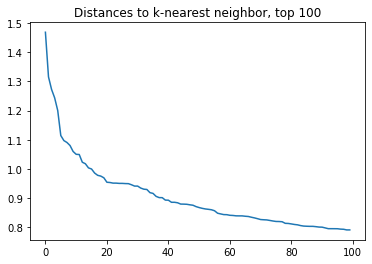

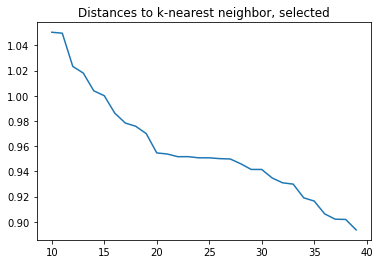

In [56]:
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing

#normalize data to identify outliers
scaler = preprocessing.MinMaxScaler()
X= scaler.fit_transform(X_train)

#determine k nearest neighbors ()
k=3
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

#plot Distances to k-nearest neighbor, top 100
plt.title('Distances to k-nearest neighbor, top 100')
top_distance_min=0
top_distance_max=100
plt.plot(indices[top_distance_min:top_distance_max,0],-np.sort(-distances[:,k])[top_distance_min:top_distance_max])
plt.show()

#plot Distances to k-nearest neighbor, selected
plt.title('Distances to k-nearest neighbor, selected')
top_distance_min=10
top_distance_max=40
plt.plot(indices[top_distance_min:top_distance_max,0],-np.sort(-distances[:,k])[top_distance_min:top_distance_max])
plt.show()

In [57]:
#k= number of outliers // approx. 10% of data 
num_outliers= 181
outlier_indices=np.argpartition(distances[:,1],-num_outliers)[-num_outliers:]
inlier_indices=np.delete(indices[:,0], outlier_indices)

#print("Indices of outliers: ",outlier_indices)
#print("Indices of inliers: ",inlier_indices)
#print("Distances of outliers: ",distances[outlier_indices,1])
#print("Max 10 distances: ",-np.sort(-distances[:,1])[0:10])

# select all rows that are not outliers (inlier=1, outlier=-1)
X_train_red, y_train_red = X_train[inlier_indices, :], y_train[inlier_indices]
# Inliers vs. Outliers
print(bold("Inliers: "),blue(X_train_red.shape[0]),bold("Outliers"),blue(X_train.shape[0]-X_train_red.shape[0]),"\n")
model_02 = reg_train_test(X_train_red ,X_test, y_train_red, y_test)


Inliers:  9930 Outliers 181 

Mean Absolute Error: 3701269.0

Regression coefficients: 
[-2.66140418e-05 -1.11039855e-12 -1.06232290e+02  6.83801450e+02
  6.92830605e+01 -1.14037899e+01  5.55180320e+02 -1.61444445e-01
  4.29553150e+02 -7.27568104e+01 -6.98238242e+02  6.10740394e+02
  3.32097009e+02 -2.62813948e+02  7.26399687e+04  4.49376260e+02
  1.33721591e+04 -2.87383171e+01  5.17812420e+01 -9.88158223e+01
 -1.15193309e+01 -1.20073288e+03  9.11509529e+03  7.91436241e+03]

Prediction Examples:
0 Actual y: 550000.0 Predicted y: -869309.0
1 Actual y: 337000.0 Predicted y: 3726085.0
2 Actual y: 840000.0 Predicted y: 935088.0
3 Actual y: 780000.0 Predicted y: 4053502.0
4 Actual y: 247000.0 Predicted y: 2634740.0


Method 3: based on density clustering (Multivariate outlier handling)

In [58]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.42, min_samples=5).fit(X)

inliers=[]
outliers=[]
index_upper=distances[:,1].size

for index in range (0,index_upper):
    if clustering.labels_[index] == -1:
        outliers.append([index, distances[index,1]])
    else:
        inliers.append([index, distances[index,1]])

inliers_df=pd.DataFrame(inliers,columns=['index','distance'])
outliers_df=pd.DataFrame(outliers,columns=['index','distance'])
# print("inliers: ",inliers_df.describe())
# print("\noutliers: ",outliers_df.describe())

In [59]:
# select all rows that are not outliers (inlier=1, outlier=-1)
X_train_red, y_train_red = X_train[inliers_df['index'], :], y_train[inliers_df['index']]

# Inliers vs. Outliers
print(bold("Inliers: "),blue(X_train_red.shape[0]),bold("Outliers"),blue(X_train.shape[0]-X_train_red.shape[0]))
model_03 = reg_train_test(X_train_red,X_test,y_train_red, y_test)

Inliers:  7639 Outliers 2472
Mean Absolute Error: 3860085.0

Regression coefficients: 
[-1.30110875e-04  2.51449737e-12 -1.36311532e+02  8.45888580e+02
  7.09088799e+01 -1.77170727e+01  7.76646114e+02  2.18278728e-11
  6.01959192e+02 -2.17951259e+00 -7.39245450e+02  6.50282667e+02
  7.22824400e+01 -1.37356011e+00  7.90884567e+04  0.00000000e+00
  1.48858140e+04 -3.32139227e+01  6.28520436e+01  6.81302307e+01
 -4.94894332e+01  9.77446638e+01  9.02416324e+03  9.12190791e+03]

Prediction Examples:
0 Actual y: 550000.0 Predicted y: -1746339.0
1 Actual y: 337000.0 Predicted y: 3556240.0
2 Actual y: 840000.0 Predicted y: 805180.0
3 Actual y: 780000.0 Predicted y: 4294188.0
4 Actual y: 247000.0 Predicted y: 2149434.0


> Conclusion

In [61]:
print(maeList)
for i, model in enumerate(maeList):
    print(f'model: {i}: {model}')

[6328488.0, 3585970.0, 3701269.0, 3860085.0]
model: 0: 6328488.0
model: 1: 3585970.0
model: 2: 3701269.0
model: 3: 3860085.0


##### Noise

##### Transformed, standardized or normalized

#### Data Reduction issues

##### Feature Selection / Instance Selection

> hinweise aus der vorlesung die interessant sein könnten:
* principal components
* EFA – Determine number of factors

#### Algorithm Selection: Experiment with different regression algorithms, e.g. linear regression, polynomial regression, regression trees etc.


pass

####  Hyper-parameter Tuning: Change the hyper-parameters of your algorithms (e.g.„degree“ in case of polynomial regression)

pass

## Modeling Continued

## Evaluation